In [24]:
from __future__ import print_function
%run 'Common.ipynb'

In [26]:
from wndcharm.FeatureSpace import FeatureSpace
#fname = 'master_fof_7_6_8'
#fname = 'medial_7_6_8_delta_3bin'
fname = 'medial_7_6_8_delta_womac'
f=FeatureSpace.NewFromFileOfFiles( os.path.join('data',fname+'.fof'), long=True )
f.ToFitFile(os.path.join('data',fname+'.fit'))

LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=0 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=1 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=0>
LOADED  <FeatureVector "T2_map_Resliced_Slice6-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=1>
LOADED  <FeatureVector "T2_map_Resliced_Slice8-l.sig" label="0" n_features=2919 grp=2 seq=0 fs_col=2>
LOADED  <FeatureVector "T2_map_Resliced_Slice7-l.sig" label="0" n_features=2919 gr

In [3]:
contig_mat = f.ContiguousDataMatrix()
print (contig_mat)
print (f._contiguous_ground_truth_labels)

mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
print (mat_vals)

mat_list,class_vals = get_class_mat_list (contig_mat, mat_vals)
print (mat_list)
print (class_vals)


[[  2.46300000e+03   5.44220000e-02   2.34303000e-01 ...,  -4.20041000e+04
    1.33342000e+05   7.16966000e-01]
 [  2.46100000e+03   3.82510000e-02   4.73540000e-02 ...,  -5.46250000e+04
    1.36239000e+05   7.25326000e-01]
 [  2.46300000e+03   2.86680000e-02   2.27273000e-01 ...,  -3.12424000e+04
    1.15157000e+05   7.13205000e-01]
 ..., 
 [  2.40200000e+03   7.63360000e-02   1.62866000e-01 ...,  -6.03631000e+04
    1.30804000e+05   7.21693000e-01]
 [  2.45000000e+03   1.28302000e-01   7.62710000e-02 ...,  -5.37427000e+04
    1.35765000e+05   7.17335000e-01]
 [  2.43000000e+03   1.49250000e-02   4.86660000e-02 ...,  -4.15241000e+04
    1.06458000e+05   7.17794000e-01]]
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3', '1', '1', '2', '4', '1', '1', '3', '2', '1', '1', '2', '3', '2', '1', '2', '3', '2', '1', '2', '3', '1', '1', '2', '3', '2', '1', '3', '2', '2', '4', '4', '3', '2', '2',

In [21]:
nfeatures = 200
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
mat_list,class_vals = get_class_mat_list (contig_mat, mat_vals)

class_sizes = [m.shape[0] for m in mat_list]
niter = np.product ( class_sizes )
n_classes = len(class_vals)
n_correct = np.asarray( [0]*n_classes)
train,test = round_robin_iteration (0,mat_list)
print ('Features          : {}'.format(nfeatures))
print ('Classes           : {}'.format(n_classes))
print ('Class sizes       : {}'.format(class_sizes))
print ('Train class sizes : {}'.format([x.shape[0] for x in train]))
print ('Iterations        : {}'.format(niter))
for iter_idx in range ( niter ):
    # Split
    train,test = round_robin_iteration (iter_idx,mat_list)
    contig_train_mat, contig_train_vals = list_to_contig_mat (train, class_vals)
    contig_test_mat, contig_test_vals = list_to_contig_mat (test, class_vals)

    # Normalize
    norm_train, norm_test = normalize (contig_train_mat, contig_test_mat)
    
    # Reduce
#    feature_weights = Pearson(norm_train, contig_train_vals)
    feature_weights = Fisher(norm_train, contig_train_vals)
    sorted_train, sorted_test = weigh_sort (norm_train, norm_test, feature_weights)

    # Classify
    preds,pred_vals = WND5(sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals)

#    preds = rand_forest_clf (sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals, iter_idx)
#    preds = rand_forest_clf (sorted_train[:,:nfeatures], np.asarray([norm_test[1][:,:nfeatures],sorted_test[0][:,:nfeatures]]), contig_train_vals, iter_idx)
    for pred_idx in range (len(preds)):
        if (preds[pred_idx] == contig_test_vals[pred_idx]):
            n_correct[pred_idx] += 1
    cumul_acc = [round ((float(x) / (float(iter_idx)+1.0)),3) for x in n_correct]
    print ("\rIteration {}; Predictions: {}; cumulative accuracies: {}".format(iter_idx, preds, cumul_acc), end="")


Features          : 200
Classes           : 3
Class sizes       : [28, 28, 12]
Train class sizes : [11, 11, 11]
Iterations        : 9408
Iteration 86; Predictions: [ 0.  1.  0.]; cumulative accuracies: [0.644, 0.218, 0.103]

KeyboardInterrupt: 

### 2 classes
    200 features, RFC
    Iteration 1119; Predictions: [ 0.  0.]; cumulative accuracies: [0.73125, 0.7294642857142857]
    200 features, WND5
    Iteration 1119; Predictions: [ 0.  0.]; cumulative accuracies: [0.7366071428571429, 0.7598214285714285]
    100 features, WND5
    Iteration 1119; Predictions: [ 0.  0.]; cumulative accuracies: [0.75, 0.7205357142857143]
    200 features, Fisher, WND5
    Iteration 1119; Predictions: [ 0.  0.]; cumulative accuracies: [0.74, 0.759]

### 3 classes (unaffected, low, high)
    200 features, Fisher, WND5
    Iteration 9407; Predictions: [ 0.  1.  1.]; cumulative accuracies: [0.626, 0.403, 0.479]

In [26]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]

nfeatures = 11
niter = contig_mat.shape[0]
print ('Train class sizes : {}'.format(contig_mat.shape[0]-1))
print ('Features          : {}'.format(nfeatures))
print ('Iterations        : {}'.format(niter))
predictions = []
actual = []
for iter_idx in range ( niter ):
    # Split
    contig_train_mat = np.delete(contig_mat,[iter_idx],axis=0)
    contig_test_mat = np.asarray([contig_mat[iter_idx]])

    contig_train_vals = np.delete (mat_vals, [iter_idx])
    contig_test_vals = np.asarray ([mat_vals[iter_idx]])

    # Normalize
    norm_train, norm_test = normalize (contig_train_mat, contig_test_mat)
    
    # Reduce
    feature_weights = Pearson(norm_train, contig_train_vals)
    sorted_train, sorted_test = weigh_sort (norm_train, norm_test, feature_weights)

    # Classify
    #preds,pred_val = WND5(sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals)
    pred_val = rand_forest_reg (sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals, iter_idx)
    #pred_val = lin_reg (sorted_train[:,:nfeatures], sorted_test[:,:nfeatures], contig_train_vals)
    print ('\rIteration {}; Predictions: {}; actual: {}'.format(iter_idx, pred_val[0], mat_vals[iter_idx]), end="")
    predictions.append (pred_val[0])
    actual.append (mat_vals[iter_idx])

score, p_value = pearsonr(predictions, actual)
score *= score
print ()
print ('R^2: {}, p-value: {}'.format (score, p_value))


Train class sizes : 39
Features          : 11
Iterations        : 40
Iteration 17; Predictions: 27.65; actual: 35.1

KeyboardInterrupt: 

### lots of bins (how many ???)
    200 features RandForReg
    R^2: 0.100336411037, p-value: 0.0464318824205
    20 features lin reg:
    R^2: 0.0491493694884, p-value: 0.169178264743
    20 features RandForReg
    R^2: 0.0595653398403, p-value: 0.129095037849
    100 features RandForReg
    R^2: 0.0395069277481, p-value: 0.218869033287
    100 features RandForReg - binned, 8 bins.
    R^2: 0.0197249101125, p-value: 0.387377038132

### three womac bins (unaffected, low, high)
    300 features WND5
    R^2: 0.111175526602, p-value: 0.00546021404546
    300 features RFR
    R^2: 0.112414217909, p-value: 0.00519089966103
    14 features linreg
    R^2: 0.0863858861628, p-value: 0.0149849168768
    15 features linreg
    R^2: 0.0973082478526, p-value: 0.00960815745761
    16 features linreg
    R^2: 0.105748921257, p-value: 0.00681313704582


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


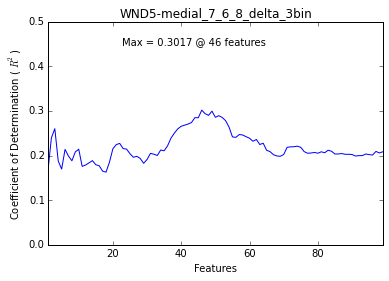

In [13]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_WND5 = R2_vs_N_features (contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('WND5-'+fname,feat_range,r_squareds_WND5)

Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


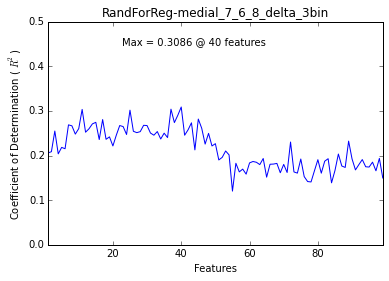

In [16]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_RFR = R2_vs_N_features (contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('RandForReg-'+fname,feat_range,r_squareds_RFR)


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


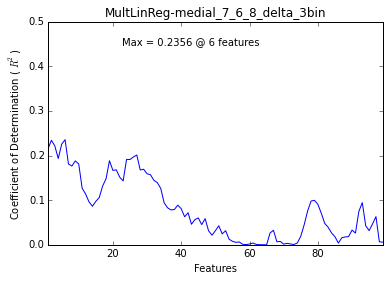

In [18]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_Lin = R2_vs_N_features (contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('MultLinReg-'+fname,feat_range,r_squareds_Lin)


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


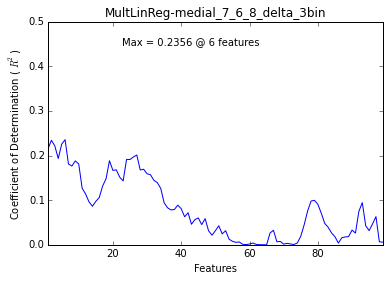

In [20]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_Lin = R2_vs_N_features (lin_reg,contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('MultLinReg-'+fname,feat_range,r_squareds_Lin)


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


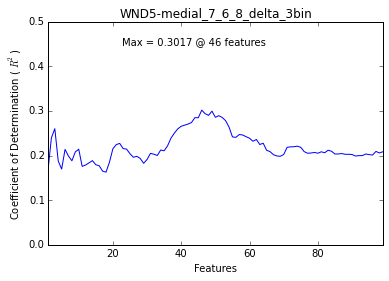

In [23]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_WND5 = R2_vs_N_features (WND5_Reg,contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('WND5-'+fname,feat_range,r_squareds_WND5)

Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


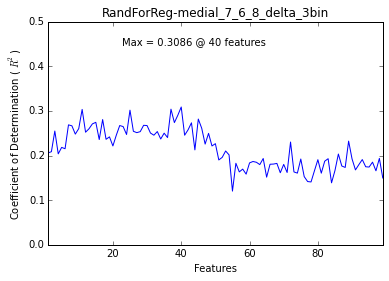

In [25]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_RFR = R2_vs_N_features (rand_forest_reg, contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('RandForReg-'+fname,feat_range,r_squareds_RFR)


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


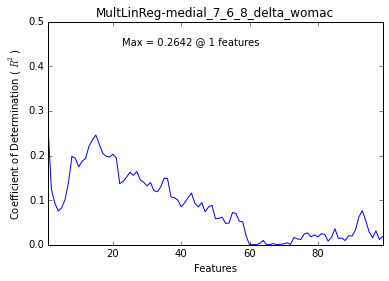

In [27]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_Lin = R2_vs_N_features (lin_reg,contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('MultLinReg-'+fname,feat_range,r_squareds_Lin)


Train class sizes : 67
N Features        : 1-99
Iterations        : 68
Iteration 67
Calculating R^2
N features 99


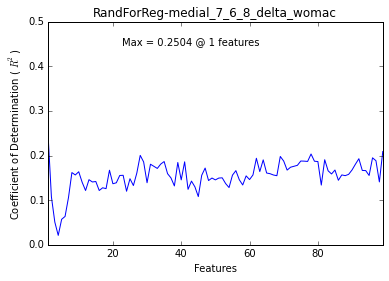

In [29]:
contig_mat = f.ContiguousDataMatrix()
mat_vals = [float(x) for x in f._contiguous_ground_truth_labels]
feat_range = range (1,100)

r_squareds_RFR = R2_vs_N_features (rand_forest_reg, contig_mat,mat_vals,feat_range)

Graph_NFeat_vs_R2 ('RandForReg-'+fname,feat_range,r_squareds_RFR)
